In [ ]:
import os 
import sys
sys.path.append("../galess")
import lens_stat as ls
import ls_utils as utils
import lens_plot

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
M_array     = np.linspace(-13 , -25 , 25)
sigma_array = np.linspace(100 , 400 , 31)
zl_array    = np.linspace(0.  , 2.5 , 26)
zs_array    = np.linspace(0.  , 10  , 21)
min_SNR     = 20
arc_mu_thr  = 3

surveys_titles = ['COSMOS Web F115W', 'COSMOS Web F277W', 'COSMOS HST i band', 
'EUCLID Wide VIS', 'Roman HLWA J', 'DES i band', 'LSST i band', 
'SUBARU HSC SuGOHI i band', 'PEARLS NEP F277W']

for title in surveys_titles[2:4]:
     survey_params = utils.read_survey_params(title, VERBOSE = 0)

     limit    = survey_params['limit']
     cut      = survey_params['cut']
     area     = survey_params['area']
     seeing   = survey_params['seeing']
     exp_time_sec = survey_params['exp_time_sec']
     pixel_arcsec = survey_params['pixel_arcsec']
     zero_point_m = survey_params['zero_point_m']
     sky_bckgnd_m = survey_params['sky_bckgnd_m']
     photo_band   = survey_params['photo_band']

     try:
          matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
     except ValueError:
          print('FILE do NOT exist - RUNNING MODEL')
          matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                      sigma_array, zl_array, zs_array, M_array, limit, area, 
                                                                      seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, pixel_arcsec, 
                                                                      photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                      LENS_LIGHT_FLAG = False, SIE_FLAG = True)

          matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                      sigma_array, zl_array, zs_array, M_array, limit, area, 
                                                                      seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, pixel_arcsec, 
                                                                      photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                      LENS_LIGHT_FLAG = True, SIE_FLAG = False)

          utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)

     _PLOT_FOR_KEYNOTE = 1
     lens_plot.set_plt_param(PLOT_FOR_KEYNOTE = _PLOT_FOR_KEYNOTE)
     fig, ax = plt.subplots(2, 2, figsize=(11, 10), sharex=False, sharey=False)
     plt.subplots_adjust(wspace=.15, hspace=.2)
     lens_plot.plot_z_sigma_distributions(fig, ax, title, zl_array, zs_array, sigma_array,
                                   Theta_E_LL, matrix_LL, Theta_E_noLL, matrix_noLL,
                                   PLOT_FOR_KEYNOTE = _PLOT_FOR_KEYNOTE, LOG = 0, SMOOTH = 1, SAVE = 0)
     plt.show()

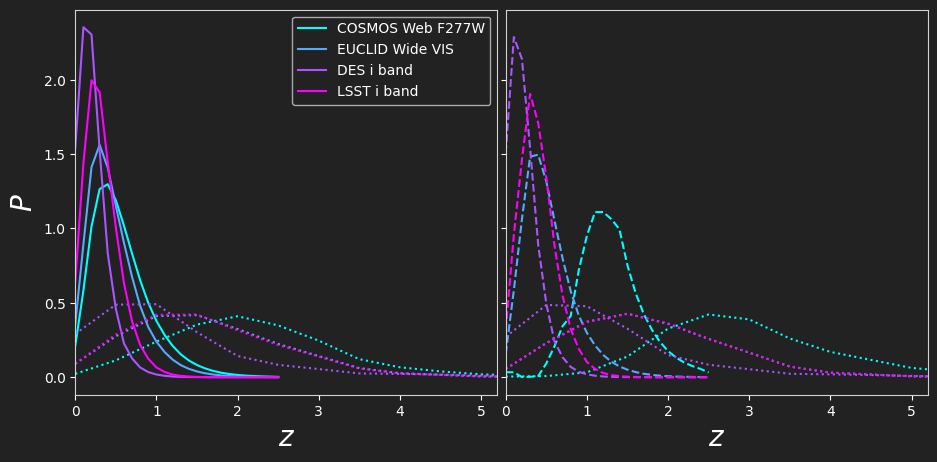

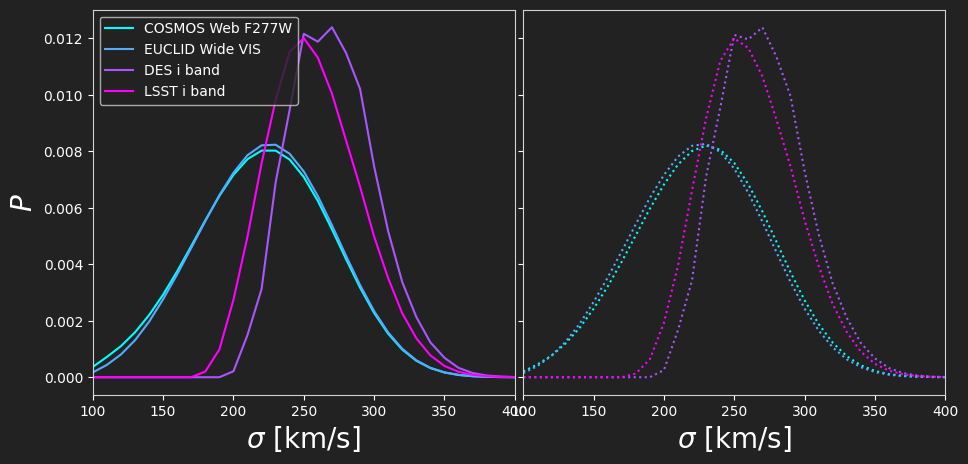

In [11]:
surveys_titles = ['COSMOS Web F115W', 'COSMOS Web F277W', 'COSMOS HST i band', 
'EUCLID Wide VIS', 'Roman HLWA J', 'DES i band', 'LSST i band', 
'SUBARU HSC SuGOHI i band', 'PEARLS NEP F277W']

surveys_selection = ['COSMOS Web F277W', 'EUCLID Wide VIS', 'DES i band', 'LSST i band']

lens_plot.compare_z_distributions_surveys(surveys_selection, sigma_array, zl_array, zs_array)
lens_plot.compare_sigma_distributions_surveys(surveys_selection, sigma_array, zl_array, zs_array)